<a href="https://colab.research.google.com/github/cfsarmiento/GenAI-Research/blob/main/ChatGPT_poll_composite_vars_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ChatGPT Poll Composite Var creation and Analysis
Modified by: EL

Things added, changed:
- Added helper class for PCA-weighted composite socre creation
- Read the ChatGPT-Clean.csv data
- Relabeled the variables for readability purposes (may still need more changes)
- Recoded Likert vars to numbers (int)
- COmpute composite scores and conbach alphas on subsets of variables.

Singleton variable are due to the fact that the cronbach-alpha coeff was below 0.7


In [ ]:
#!pip install vaderSentiment --quiet
#!pip install pingouin --quiet
!pip install openpyxl --quiet

In [ ]:
# Imports
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pingouin as pg
import researchpy as rp  # for statistical tests
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # for sentiment analysis
import warnings
warnings.filterwarnings('ignore')

## Helper class - PCA-weighted  composite score creation

In [ ]:
class LikertCompositeCalculator:
    def __init__(self, data, withPCA=True):
        # Standardization: This is needed for PCA - values are measured in stddevs:  (xi-xi_mean)/xi_sd
        # Also to be able to compare likert scale variables with different scales
        # the withPCA boolean value determines whether PCA is used to compte the weights, or if the variables are just averaged
        self.data = zscore(data, ddof=1)
        self.withPCA = withPCA

    def calc_ca(self):
        # Calculated manually (checking the package)
        k = self.data.shape[1]
        if k>1:
          variance_sum = self.data.var(axis=0, ddof=1).sum()
          total_variance = self.data.sum(axis=1).var(ddof=1)
          cronbach_alpha = (k / (k - 1)) * (1 - (variance_sum / total_variance))
        else:
          cronbach_alpha = 1
        return cronbach_alpha

    def calc2_ca(self):
        # USing pingouin
        if  self.data.shape[1] >1:
          cronbach_alpha =pg.cronbach_alpha(self.data)
        else:
          cronbach_alpha = 1
        return cronbach_alpha

    def calc_composite_score(self):
        # Step 1: Perform PCA (data already standardized)
        pca = PCA()
        pca.fit(self.data)

        # Step 2: Calculate Weights
        if self.withPCA:
          weights = pca.components_[0] / np.sum(pca.components_[0])
        else:
         k = self.data.shape[1]
         broadcast_value= (1.0/k)
         weights = np.full(k, broadcast_value)

        # Step 3: Calculate Composite Scores
        composite_scores = np.dot(self.data, weights)

        return composite_scores, weights

## Read in clean poll results

In [ ]:
# Read in clean poll results
# I placed the file you provided in my website at Marist, was easier to load the data for me
data = pd.read_csv('https://foxweb.marist.edu/users/jf4n/Research/ChatGPTSurvey/ChatGPT-Clean.csv')

In [ ]:
data.sample(20)

,Q2,Q4,Q5,Q6,Q7_1,Q7_2,Q7_3,Q8_1,Q8_2,Q8_3,...,Q15_9,Q17,Q19,Q21,Q22,Q23,sex,age,occupation/school,student/faculty
276,A good amount,From a friend,To obtain significant help with a project,Curiosity,Somewhat agree,Strongly agree,Strongly agree,Strongly disagree,Strongly disagree,Somewhat disagree,...,Somewhat disagree,Somewhat agree,Somewhat disagree,Very unlikely,Somewhat unlikely,i don't like it because it does not give accur...,Female,18-21,Social & Behavioral Sciences,Student
305,A great deal,From a friend,To obtain significant help with a project,To get started with a project,Strongly agree,Somewhat agree,Neither agree nor disagree,Strongly agree,Somewhat agree,Somewhat disagree,...,Somewhat agree,Strongly agree,Strongly agree,Very likely,Somewhat likely,NaN,Female,18-21,NaN,NaN
371,A great deal,From the news,To obtain significant help with a project,To obtain significant help with a project,Somewhat agree,Strongly agree,Somewhat agree,Strongly agree,Somewhat agree,Somewhat agree,...,Strongly agree,Strongly agree,Strongly disagree,Neither likely nor unlikely,Neither likely nor unlikely,NaN,NaN,NaN,NaN,NaN
279,A great deal,From a friend,Other; please specify,Other; please specify,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,...,Strongly agree,Strongly agree,Strongly agree,Very likely,Somewhat likely,"I like it, I think people should use it in a s...",Female,22-25,NaN,NaN
347,A good amount,From a friend,To aid in completion of a project,To aid in completion of a project,Strongly agree,Strongly agree,Somewhat agree,Strongly agree,Strongly agree,Strongly agree,...,Strongly agree,Strongly agree,Strongly agree,Very likely,Somewhat likely,It is useful for getting ideas/completing busy...,Male,18-21,NaN,NaN
341,A good amount,From the news,To aid in completion of a project,Other; please specify,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat disagree,Neither agree nor disagree,...,Strongly disagree,Somewhat agree,Neither agree nor disagree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,A good amount,Other,To get started with a project,Curiosity,Somewhat agree,Somewhat agree,Strongly agree,Somewhat agree,Somewhat agree,Neither agree nor disagree,...,Strongly agree,Somewhat agree,Neither agree nor disagree,Somewhat unlikely,Somewhat unlikely,Influential,Male,18-21,Communications & Arts,Student
259,Nothing at all,None,To obtain significant help with a project,To get started with a project,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Strongly agree,...,Somewhat agree,Strongly agree,Strongly disagree,Very unlikely,Very unlikely,NaN,Female,22-25,Social & Behavioral Sciences,Student
106,Nothing at all,From this questionnaire,To aid in completion of a project,To get started with a project,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree,Somewhat agree,Somewhat agree,...,Strongly agree,Strongly agree,Strongly disagree,Very likely,Very likely,I think ChatGPT could be very beneficial for s...,Female,18-21,Communications & Arts,Student
317,A good amount,Other,To obtain significant help with a project,To aid in completion of a project,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,...,Strongly agree,Neither agree nor disagree,Somewhat agree,Neither likely nor unlikely,Very unlikely,While ChatGPT is an advancement with countless...,Male,42-45,NaN,NaN


In [ ]:
#data.info()

In [ ]:
new_column_names = {'Q2':    'Q2_AWARENESS',
                    'Q4':    'SOURCE',
                    'Q5':    'Q5_REASON_STUDENT',
                    'Q6':    'Q6_REASON_PROF',
                    'Q7_1':  'Q71_BENEFITS',
                    'Q7_2':  'Q72_LIMITATIONS',
                    'Q7_3':  'Q73_IMPLICATIONS',
                    'Q8_1':  'Q81_LIKELY_PRODUCTIVE',
                    'Q8_2':  'Q82_PRODUCTIVE_STUDENT',
                    'Q8_3':  'Q83_PRODUCTIVE_PROF',
                    'Q8_4':  'Q84_PRODUCTIVE_PERSON',
                    'Q9_1':  'Q91_PLAG_STUDENT',
                    'Q9_2':  'Q92_PLAG_PROF',
                    'Q9_3':  'Q93_PLAG_PERSON',
                    'Q9_4':  'Q94_CAUGHT_PLAG',
                    'Q10':   'Q10_SOC_IMPACT',
                    'Q11':   'Q11_HIGHERED_BENEFIT',
                    'Q12':   'Q12_RESP_USE',
                    'Q13':   'Q13_FREQ_USE',
                    'Q14':   'Q14_RESP_REASON_USE',
                    'Q15_1': 'Q151_RESP_WILL_USE',
                    'Q15_2': 'Q152_RESP_BENEFIT',
                    'Q15_3': 'Q153_RESP_PRODUCTIVE',
                    'Q15_4': 'Q154_RESP_FEEL_PLAG',
                    'Q15_5': 'Q155_RESP_TRUST_OUTPUT',
                    'Q15_6': 'Q156_RESP_USE_OUTPUT',
                    'Q15_7': 'Q157_RESP_WILL_PLAG',
                    'Q15_8': 'Q158_RESP_PRODUCTIVE',
                    'Q15_9': 'Q159_RESP_IMPACTED',
                    'Q17':   'Q17_ACCURATE_OUTPUT_DELIVERY',
                    'Q19':   'Q19_ACCURATE_OUTPUT_COUNTRY',
                    'Q21':   'Q21_TRUST_OUTPUT_COAT',
                    'Q22':   'Q22_USE_OUTPUT_COAT',
                    'Q23':   'Q23_THOUGHTS',
                    'sex':   'GENDER',
                    'age':   'AGE_RANGE',
                    'occupation/school': 'OCCUP_SCHOOL',
                    'student/faculty':   'OCCUPATION'

					}

In [ ]:
df = data.rename(columns=new_column_names)
#df.info()

## Check missing values

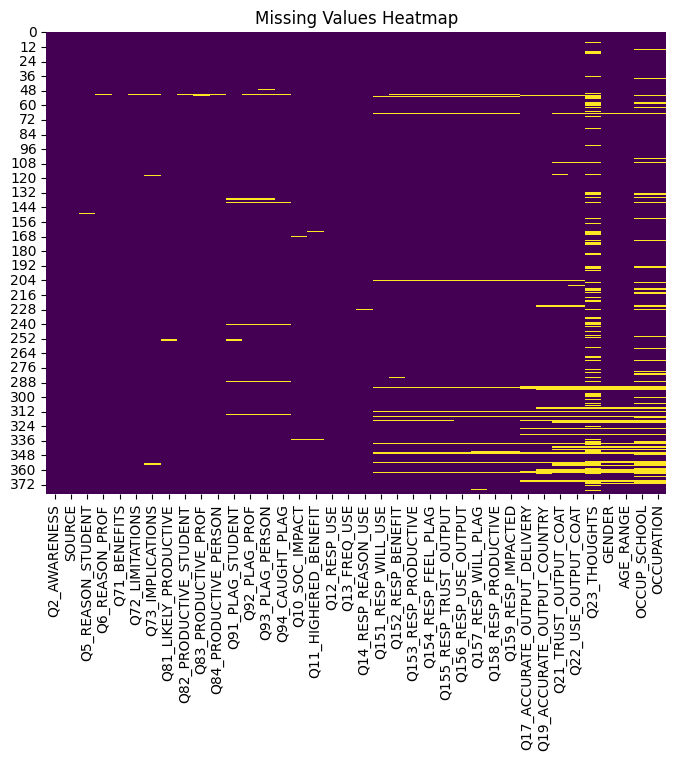

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

## Remove nulls, recode and drop Q23-THOUGHTS

In [ ]:
df1 = df.drop("Q23_THOUGHTS", axis=1).dropna()
df1['OCCUPATION'] = df1['OCCUPATION'].replace('Professor/Faculty', 'Instructor')
df1['GENDER'] = df1['GENDER'].replace('Non-binary / third gender', 'NB_3rd_gender')
df1['GENDER'] = df1['GENDER'].replace('Prefer not to say', 'PNTS')
df1['SOURCE'] = df1['SOURCE'].replace('From a colleague', 'colleague')
df1['SOURCE'] = df1['SOURCE'].replace('From a family member', 'familymember')
df1['SOURCE'] = df1['SOURCE'].replace('From a family member', 'familymember')
df1['SOURCE'] = df1['SOURCE'].replace('From a family member', 'familymember')
df1['SOURCE'] = df1['SOURCE'].replace('From the news', 'news')
df1['SOURCE'] = df1['SOURCE'].replace('From this questionnaire', 'questionnaire')
df1['SOURCE'] = df1['SOURCE'].replace('None', 'none')

print(df1.shape[0])
#df1["OCCUPATION"].sample(20)

302


## Plot  the distribution by demographic vars

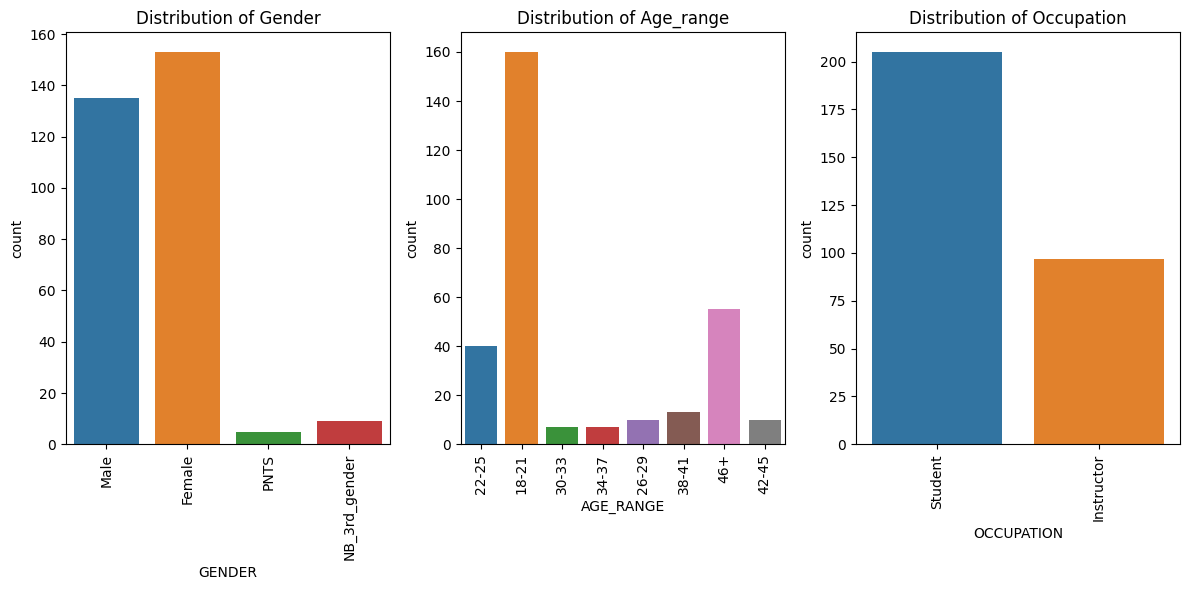

In [ ]:
# Set up the 3x1 plot grid
demog_features =['GENDER','AGE_RANGE','OCCUPATION']
fig, axes = plt.subplots(nrows=1, ncols=len(demog_features), figsize=(12, 6))

# Loop through each demog_feature and create a count plot
for i, column in enumerate(demog_features):
    sns.countplot(x=column, data=df1, ax=axes[i])
    axes[i].set_title(f'Distribution of {column.capitalize()}')
    axes[i].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
df1['SOURCE'].unique()

array(['news', 'From a friend', 'familymember', 'none', 'questionnaire',
       'Other', 'colleague'], dtype=object)

## Recoding of Likert vars

In [ ]:
##Likert (1-3) vars ----------------------------------------------------------------
likert3_mapping1 = {'Very much so':1,
                   'Somewhat':2,
                   'Not at all':3}
df1['Q10_SOC_IMPACT'] = df1['Q10_SOC_IMPACT'].map(likert3_mapping1)
df1['Q11_HIGHERED_BENEFIT'] = df1['Q11_HIGHERED_BENEFIT'].map(likert3_mapping1)

##Likert (1-4) vars ---------------------------------------------------------------
likert4_mapping1 = {'A great deal':1,
                   'A good amount':2,
                   'A little':1,
                   'Nothing at all':4}

df1['Q2_AWARENESS'] = df1['Q2_AWARENESS'].map(likert4_mapping1)


likert4_mapping2 = {'Quite a lot':1,
                   'A good amount':2,
                   'A little':1,
                   'Not at all':4}

df1['Q12_RESP_USE'] = df1['Q12_RESP_USE'].map(likert4_mapping2)


likert4_mapping3 = {'11 or more times':1,
                    '6 to 10':2,
                    '1 to 5':3,
                    '0':4}

df1['Q13_FREQ_USE'] = df1['Q13_FREQ_USE'].map(likert4_mapping3)

##Likert (1-5) vars -----------------------------------------------
likert5_mapping1 = {'Strongly agree':1,
                  'Somewhat agree':2,
                  'Neither agree nor disagree':3,
                  'Somewhat disagree':4,
                  'Strongly disagree':5}

inverse_likert5_mapping1 = {'Strongly agree':5,
                           'Somewhat agree':4,
                           'Neither agree nor disagree':3,
                           'Somewhat disagree':2,
                           'Strongly disagree':1}

for colname  in ['Q71_BENEFITS','Q72_LIMITATIONS','Q73_IMPLICATIONS',
                'Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON',
                'Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON','Q94_CAUGHT_PLAG',
                'Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE','Q154_RESP_FEEL_PLAG',
                'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q157_RESP_WILL_PLAG','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED',
                'Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY'] :

     #keep direction (1-5)
     if colname in ['Q71_BENEFITS', 'Q72_LIMITATIONS','Q73_IMPLICATIONS',
                    'Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON',
                    'Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON',
                    'Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE',
                    'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED',
                    'Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY']:
        df1[colname] = df1[colname].map(likert5_mapping1)
     else:
        df1[colname] = df1[colname].map(inverse_likert5_mapping1)


likert5_mapping2 = {'To obtain significant help with a project':1,
                    'To aid in completion of a project':2,
                    'To get started with a project':3,
                    'Curiosity':4,
                    'I have not used ChatGPT':5}
df1['Q14_RESP_REASON_USE'] = df1['Q14_RESP_REASON_USE'].map(likert5_mapping2)

likert5_mapping3 = {'Very likely':1,
                    'Somewhat likely':2,
                    'Neither likely nor unlikely':3,
                    'Somewhat unlikely':4,
                    'Very unlikely':5}
df1['Q21_TRUST_OUTPUT_COAT'] = df1['Q21_TRUST_OUTPUT_COAT'].map(likert5_mapping3)
df1['Q22_USE_OUTPUT_COAT'] = df1['Q22_USE_OUTPUT_COAT'].map(likert5_mapping3)


likert5_mapping4 = {'To obtain significant help with a project':1,
                    'To aid in completion of a project':2,
                    'To get started with a project':3,
                    'Curiosity':4,
                    'Other; please specify':5}
df1['Q5_REASON_STUDENT'] = df1['Q5_REASON_STUDENT'].map(likert5_mapping4)
df1['Q6_REASON_PROF'] = df1['Q6_REASON_PROF'].map(likert5_mapping4)


In [ ]:
df1

,Q2_AWARENESS,SOURCE,Q5_REASON_STUDENT,Q6_REASON_PROF,Q71_BENEFITS,Q72_LIMITATIONS,Q73_IMPLICATIONS,Q81_LIKELY_PRODUCTIVE,Q82_PRODUCTIVE_STUDENT,Q83_PRODUCTIVE_PROF,...,Q158_RESP_PRODUCTIVE,Q159_RESP_IMPACTED,Q17_ACCURATE_OUTPUT_DELIVERY,Q19_ACCURATE_OUTPUT_COUNTRY,Q21_TRUST_OUTPUT_COAT,Q22_USE_OUTPUT_COAT,GENDER,AGE_RANGE,OCCUP_SCHOOL,OCCUPATION
0,1,news,1,2,4,4,4,3,3,3,...,5,1,2,3,5,5,Male,22-25,Management,Student
1,2,news,3,2,1,1,1,1,2,1,...,2,1,1,3,2,2,Male,18-21,CS & Math,Student
2,2,From a friend,3,3,1,2,2,1,2,2,...,2,2,1,1,2,2,Female,18-21,CS & Math,Student
3,1,familymember,2,2,1,1,1,2,2,2,...,2,1,2,2,2,2,Female,18-21,CS & Math,Student
4,4,From a friend,4,1,1,2,2,1,3,1,...,2,2,1,4,1,2,Female,18-21,CS & Math,Student
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,1,news,1,3,1,1,1,2,2,2,...,2,2,1,3,4,5,Female,30-33,Professor/Faculty,Instructor
375,2,news,1,4,3,1,1,3,5,4,...,3,2,5,3,5,5,PNTS,34-37,Professor/Faculty,Instructor
377,2,familymember,2,2,1,2,1,2,4,4,...,4,2,2,3,2,4,Female,22-25,Social & Behavioral Sciences,Student
378,1,news,2,4,1,3,5,1,1,1,...,1,1,1,3,2,3,Female,18-21,Social & Behavioral Sciences,Student


## Now we create subsets, compute reliability and create composites

In [152]:
# Example usage
subset_dict = {
    'AWARENESS': ['Q2_AWARENESS'],
    'REASON_STUDENT': ['Q5_REASON_STUDENT'],
    'REASON_PROFESSIONAL': ['Q6_REASON_PROF'],
    'BENEFITS': ['Q71_BENEFITS'],
    'LIMITATIONS': ['Q72_LIMITATIONS'],
    'IMPLICATIONS': ['Q73_IMPLICATIONS'],
    'WORK_PRODUCTIVITY': ['Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON'],
    'PLAGIARISM': ['Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON'],
    'SOCIAL_IMPACT': ['Q10_SOC_IMPACT'],
    'HIGHERED_BENEFIT': ['Q11_HIGHERED_BENEFIT'],
    'USAGE': ['Q12_RESP_USE','Q13_FREQ_USE','Q14_RESP_REASON_USE'],
    'RESP_USE_TRUST_BENEF': ['Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE','Q154_RESP_FEEL_PLAG',
                              'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q157_RESP_WILL_PLAG','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED'],
    'ACCURACY': ['Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY'],
    'TRUST': ['Q21_TRUST_OUTPUT_COAT','Q22_USE_OUTPUT_COAT']
}
composite_info = []
df2 = pd.DataFrame()

for subset_name, subset_variables in subset_dict.items():
        subset = df1[subset_variables]
        lcc = LikertCompositeCalculator(subset,withPCA=True)

        # Add the composite variable to the original DataFrame
        composite_var_name = subset_name
        composite_score, weights = lcc.calc_composite_score()
        df2[composite_var_name] = composite_score

        # Calculate Cronbach's alpha
        cronbach_alpha = lcc.calc_ca()
        #print(subset_name,list(zip(subset_variables,weights)),lcc.calc_ca(),'\n' )

        # Add information to the composite info list
        composite_info.append({'SubsetName': subset_name,'subset': list(zip(subset_variables,weights)), 'CronbachAlpha': cronbach_alpha})

# Create a new df, augmented with the composites
result_df = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

# Create a DataFrame to store composite information
composite_info_df = pd.DataFrame(composite_info)


In [153]:
composite_info_df['subset'][6]

[('Q81_LIKELY_PRODUCTIVE', 0.2695951460824908),
 ('Q82_PRODUCTIVE_STUDENT', 0.26392241664318844),
 ('Q83_PRODUCTIVE_PROF', 0.2783267451215751),
 ('Q84_PRODUCTIVE_PERSON', 0.18815569215274552)]

In [154]:
result_df

,Q2_AWARENESS,SOURCE,Q5_REASON_STUDENT,Q6_REASON_PROF,Q71_BENEFITS,Q72_LIMITATIONS,Q73_IMPLICATIONS,Q81_LIKELY_PRODUCTIVE,Q82_PRODUCTIVE_STUDENT,Q83_PRODUCTIVE_PROF,...,LIMITATIONS,IMPLICATIONS,WORK_PRODUCTIVITY,PLAGIARISM,SOCIAL_IMPACT,HIGHERED_BENEFIT,USAGE,RESP_USE_TRUST_BENEF,ACCURACY,TRUST
0,1,news,1,2,4,4,4,3,3,3,...,2.171730,2.373974,0.705744,-1.463215,0.969679,1.707759,0.895819,1.543423,0.254953,1.750332
1,2,news,3,2,1,1,1,1,2,1,...,-1.022405,-0.821896,-0.721571,-0.073755,-0.907521,-1.149544,-0.751619,-0.549300,-0.296804,-0.685842
2,2,From a friend,3,3,1,2,2,1,2,2,...,0.042306,0.243394,-0.587772,-0.628901,0.969679,-1.149544,-0.676335,-0.765636,-1.025810,-0.685842
3,1,familymember,2,2,1,1,1,2,2,2,...,-1.022405,-0.821896,-0.297750,-0.407348,0.969679,0.279107,-1.315724,-0.708271,-0.109550,-0.685842
4,4,From a friend,4,1,1,2,2,1,3,1,...,0.042306,0.243394,-0.141898,0.798437,-0.907521,-1.149544,0.895819,-0.631084,0.067700,-1.123160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1,news,1,3,1,1,1,2,2,2,...,-1.022405,-0.821896,-0.122395,-0.371065,0.969679,0.279107,-1.552690,-0.473446,-0.296804,1.313014
298,2,news,1,4,3,1,1,3,5,4,...,-1.022405,-0.821896,1.297468,-0.926211,0.969679,0.279107,-0.751619,0.681038,1.910223,1.750332
299,2,familymember,2,2,1,2,1,2,4,4,...,0.042306,-0.821896,0.953839,-0.369470,-0.907521,0.279107,0.895819,0.980047,0.254953,0.063638
300,1,news,2,4,1,3,5,1,1,1,...,1.107018,3.439263,-1.301245,-0.369470,0.969679,-1.149544,0.895819,-0.665683,-0.296804,-0.311102


In [155]:
#result_df.to_csv('coded_data.csv', index=False)
#composite_info_df.to_csv('composite_info_df', index=False)

In [156]:
import os
excel_filename = 'pollcodeddata.xlsx'
if os.path.exists(excel_filename):
    os.remove(excel_filename)

# Create an ExcelWriter object
with pd.ExcelWriter(excel_filename) as writer:
    # Write each DataFrame to a different worksheet
    result_df.to_excel(writer, sheet_name='coded_data', index=False)
    composite_info_df.to_excel(writer, sheet_name='composite_info', index=False)

from google.colab import files
files.download('pollcodeddata.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

___________________________________________

# Multiple regression and ANOVA
- 'AWARENESS'
- 'REASON_STUDENT'
- 'REASON_PROFESSIONAL'
- 'BENEFITS'
- 'LIMITATIONS'
- 'IMPLICATIONS'
- 'WORK_PRODUCTIVITY'
- 'PLAGIARISM'
- 'SOCIAL_IMPACT'
- 'HIGHERED_BENEFIT'
- 'USAGE'
- 'RESP_USE_TRUST_BENEF'
- 'ACCURACY'
- 'TRUST'

In [221]:
target_name = 'PLAGIARISM'

**Build OLS regression model without interactions**

In [222]:
import statsmodels.formula.api as smf

#feature_names=['AGE_RANGE', 'OCCUPATION','GENDER']

#formula = f"{target_name} ~ {' + '.join(['C(' + feature + ')' for feature in feature_names])}"
formula = f"{target_name} ~  C(AGE_RANGE) + C(OCCUPATION) + C(GENDER)"
print(formula)

# Fit the OLS regression model
lm = smf.ols(formula=formula, data=result_df).fit()

# Print the summary of the model
print(lm.summary())

PLAGIARISM ~  C(AGE_RANGE) + C(OCCUPATION) + C(GENDER)
                            OLS Regression Results                            
Dep. Variable:             PLAGIARISM   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.516
Date:                Tue, 29 Aug 2023   Prob (F-statistic):            0.00486
Time:                        23:27:54   Log-Likelihood:                -361.91
No. Observations:                 302   AIC:                             747.8
Df Residuals:                     290   BIC:                             792.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

**Build OLS regression model with interaction OCCUPATION-GENDER**

In [223]:
import statsmodels.formula.api as smf

formula = f"{target_name} ~  C(AGE_RANGE) + C(OCCUPATION) * C(GENDER)"

# Fit the OLS regression model
inter_OG_lm = smf.ols(formula=formula, data=result_df).fit()

# Print the summary of the model
print(inter_OG_lm.summary())

                            OLS Regression Results                            
Dep. Variable:             PLAGIARISM   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.960
Date:                Tue, 29 Aug 2023   Prob (F-statistic):             0.0207
Time:                        23:27:54   Log-Likelihood:                -361.89
No. Observations:                 302   AIC:                             753.8
Df Residuals:                     287   BIC:                             809.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

**Build OLS regression model with interaction AGE_OCCUPATION**

In [224]:
import statsmodels.formula.api as smf

formula = f"{target_name} ~  C(AGE_RANGE) * C(OCCUPATION) + C(GENDER)"
#formula

# Fit the OLS regression model
inter_AO_lm = smf.ols(formula=formula, data=result_df).fit()

# Print the summary of the model
print(inter_AO_lm.summary())

                            OLS Regression Results                            
Dep. Variable:             PLAGIARISM   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     2.410
Date:                Tue, 29 Aug 2023   Prob (F-statistic):            0.00131
Time:                        23:27:54   Log-Likelihood:                -354.14
No. Observations:                 302   AIC:                             746.3
Df Residuals:                     283   BIC:                             816.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

**Build OLS regression model with interaction AGE-GENDER**

In [225]:
import statsmodels.formula.api as smf

formula = f"{target_name} ~  C(AGE_RANGE) * C(GENDER) + C(OCCUPATION)"

# Fit the OLS regression model
inter_AG_lm = smf.ols(formula=formula, data=result_df).fit()

# Print the summary of the model
print(inter_AG_lm.summary())

                            OLS Regression Results                            
Dep. Variable:             PLAGIARISM   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.616
Date:                Tue, 29 Aug 2023   Prob (F-statistic):             0.0396
Time:                        23:27:54   Log-Likelihood:                -356.73
No. Observations:                 302   AIC:                             761.5
Df Residuals:                     278   BIC:                             850.5
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

-------------------------------------
## Analysis of Variance

In [226]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# One-way ANOVA
one_way_model = smf.ols(formula= 'WORK_PRODUCTIVITY ~ C(GENDER)', data=result_df).fit()
one_way_anova_table = sm.stats.anova_lm(one_way_model, typ=2)

print("One-Way ANOVA Results:")
print(one_way_anova_table)

One-Way ANOVA Results:
               sum_sq     df         F    PR(>F)
C(GENDER)    8.077919    3.0  4.916525  0.002386
Residual   163.206038  298.0       NaN       NaN


In [227]:
import statsmodels.api as sm

# Two-way ANOVA
formula = f"{target_name} ~ {' + '.join(['C(' + feature + ')' for feature in feature_names])} + {' * '.join(['C(' + feature + ')' for feature in feature_names])}"
formula = f"{target_name} ~ C(AGE_RANGE) + C(GENDER) + C(OCCUPATION) "
print(formula)
# Perform the multiway ANOVA
model = sm.formula.ols(formula, data=result_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Multiway ANOVA Results:")
anova_table

PLAGIARISM ~ C(AGE_RANGE) + C(GENDER) + C(OCCUPATION) 
Multiway ANOVA Results:


,sum_sq,df,F,PR(>F)
C(AGE_RANGE),5.516705,7.0,1.176355,0.316189
C(GENDER),2.325078,3.0,1.156839,0.326534
C(OCCUPATION),0.204555,1.0,0.305328,0.580987
Residual,194.285838,290.0,NaN,NaN


In [228]:
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

from statsmodels.stats.api import anova_lm

table1 = anova_lm(lm, inter_OG_lm,inter_AO_lm,inter_AG_lm)
print(table1)

   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     290.0  194.285838      0.0       NaN       NaN       NaN
1     287.0  194.250905      3.0  0.034933  0.017243  0.996911
2     283.0  184.542703      4.0  9.708202  3.594035  0.007068
3     278.0  187.733289      5.0 -3.190586 -0.944939  1.000000
